# R Package Dependencies

In [149]:
import pandas
import networkx 

from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf')

data = pandas.DataFrame.from_csv('../data/github-cran-150601.csv')
data['Date'] = pandas.to_datetime(data['Date'])

In [150]:
R_packages = ('R MASS Matrix base boot class cluster codetools compiler datasets foreign grDevices ' +
        'graphics grid lattice methods mgcv nlme nnet parallel rpart ' +
        'spatial splines stats stats4 survival tcltk tools translations utils').split(' ')

In [151]:
def data_for_date(data, date):
    return data.sort('Date').query('InCRAN == 1 and Date <= "{date}"'.format(date=date)).drop_duplicates(('Package'), take_last=True).fillna('').set_index('Package', inplace=False)

In [152]:
def graph_for_data(data, ignore_R = True):
    G = networkx.DiGraph()
    G.add_nodes_from(list(data.index))
    for index, row in data.iterrows():
        deps = row['Dependencies'].split(' ')
        for dep in deps: 
            if dep in nodes:
                G.add_edge(index, dep)
    if ignore_R:
        G.remove_nodes_from(R_packages)
    return G

In [153]:
def nodes_properties(G):
    isolated = networkx.isolates(G)

    for node in networkx.topological_sort(G, reverse=True):
        min_strata = len(G.node) + 1
        max_strata = 0
        for successor in G.successors(node):
            if G.node[successor]['max_strata'] > max_strata:
                max_strata = G.node[successor]['max_strata']
            if G.node[successor]['min_strata'] < min_strata:
                min_strata = G.node[successor]['min_strata']
        if min_strata == len(G.node) + 1:
            min_strata = 0
        G.node[node]['min_strata'] = min_strata + 1
        G.node[node]['max_strata'] = max_strata + 1

    packages = pandas.DataFrame.from_dict({n: {'ancestors': len(networkx.ancestors(G, n)),
                                    'descendants': len(networkx.descendants(G, n)),
                                    'out': G.out_degree(n), 
                                    'in': G.in_degree(n),
                                    'isolated': n in isolated,
                                    'min_strata': G.node[n]['min_strata'],
                                    'max_strata': G.node[n]['max_strata']} for n in G.nodes_iter()}, orient='index')
    return packages

In [154]:
dates = pandas.date_range(start='2010-01', end='2015-01', freq='6M')

In [155]:
from collections import OrderedDict

summary = OrderedDict()
graphs = OrderedDict()
props = OrderedDict()

for date in dates:     
    G = graph_for_data(data_for_date(data, date))
    p = nodes_properties(G)
    
    d = OrderedDict()
    d['nodes'] = len(G)

    nonisolated = p.query('isolated == False')
    d['nonisolated'] = len(nonisolated)
    
    d['max ancestors'] = nonisolated['ancestors'].max()
    d['max descendants'] = nonisolated['descendants'].max()
    
    #d['min_strata mean'] = nonisolated['min_strata'].mean()
    #d['max_strata mean'] = nonisolated['max_strata'].mean()
    
    d['min_strata <= 1'] = len(nonisolated.query('min_strata <= 1'))
    d['max_strata <= 1'] = len(nonisolated.query('max_strata <= 1'))
                                                 
    d['min_strata >= 3'] = len(nonisolated.query('min_strata >= 3'))
    d['max_strata >= 3'] = len(nonisolated.query('max_strata >= 3'))
    
    summary[date] = d
    graphs[date] = G
    props[date] = p

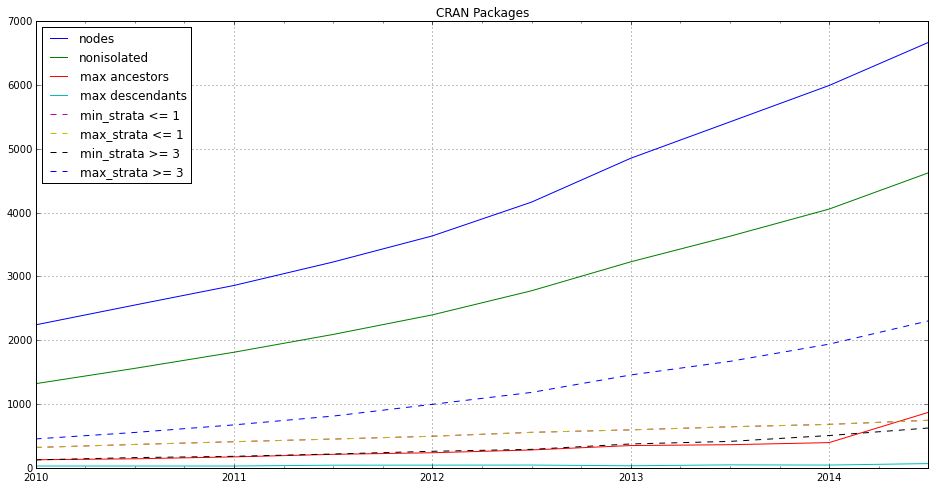

In [156]:
df = pandas.DataFrame.from_dict(summary, orient='index')
df.index = pandas.to_datetime(df.index)

ax = df.plot(style=[None, None, None, None, '--', '--', '--', '--'], title='CRAN Packages')
ax.figure.set_size_inches(16, 8)

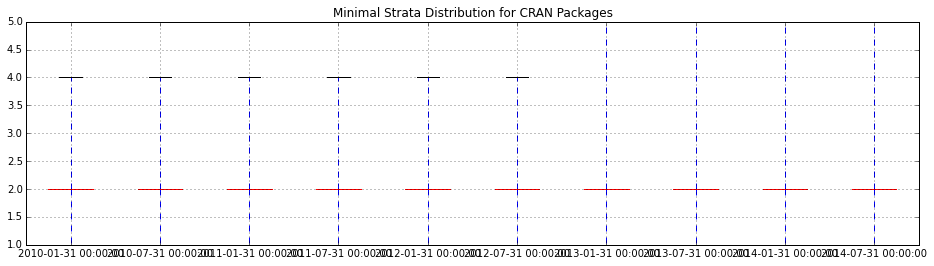

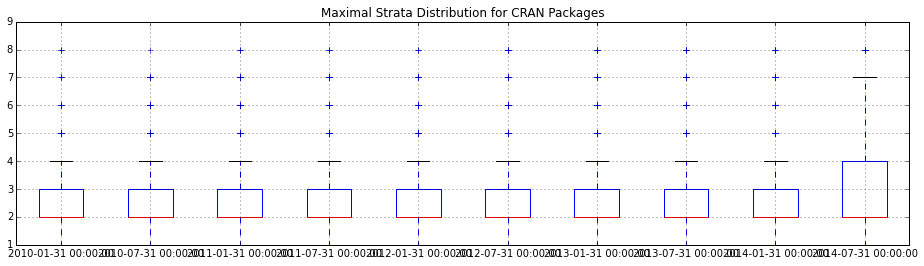

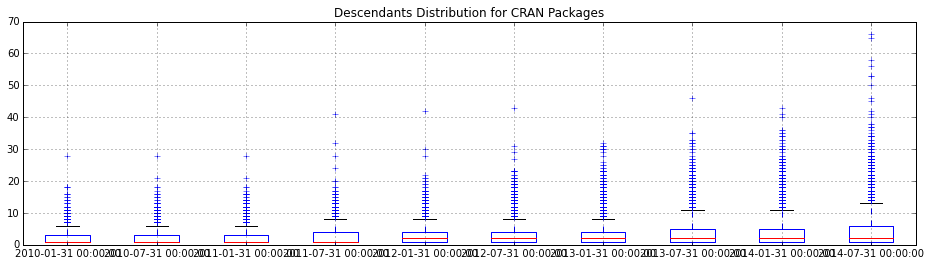

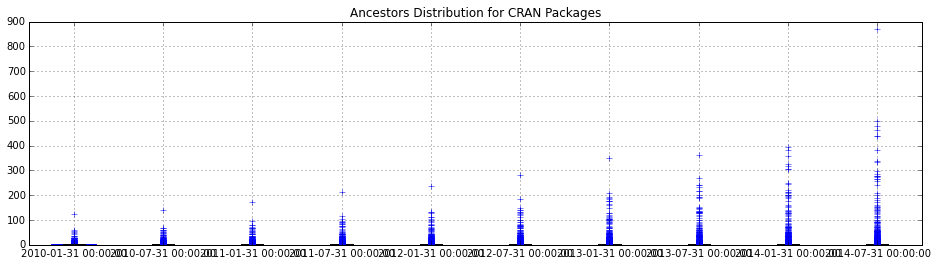

In [160]:
df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['min_strata'] for date, p in props.iteritems()})

ax = df.plot(title='Minimal Strata Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['max_strata'] for date, p in props.iteritems()})

ax = df.plot(title='Maximal Strata Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['descendants'] for date, p in props.iteritems()})

ax = df.plot(title='Descendants Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)

df = pandas.DataFrame.from_dict({date: p.query('isolated == False')['ancestors'] for date, p in props.iteritems()})

ax = df.plot(title='Ancestors Distribution for CRAN Packages', kind='box')
ax.figure.set_size_inches(16, 4)



In [167]:
df.sort('2014-07-31 00:00:00', ascending=False, inplace=False)

,2010-01-31 00:00:00,2010-07-31 00:00:00,2011-01-31 00:00:00,2011-07-31 00:00:00,2012-01-31 00:00:00,2012-07-31 00:00:00,2013-01-31 00:00:00,2013-07-31 00:00:00,2014-01-31 00:00:00,2014-07-31 00:00:00
Rcpp,3,15,28,42,80,100,148,189,305,869
plyr,28,47,68,89,131,183,210,268,360,501
RColorBrewer,22,36,53,75,111,134,176,217,383,478
stringr,0,1,11,20,34,125,183,240,319,464
mvtnorm,126,141,171,211,236,280,349,362,395,440
digest,28,41,56,77,103,128,178,235,324,437
colorspace,27,53,64,94,127,142,194,241,307,383
reshape2,NaN,NaN,0,6,10,80,120,153,214,338
bitops,27,30,45,63,90,119,178,200,246,332
zoo,56,68,94,115,134,149,187,217,251,297
